## Prototype Network

Based on the paper: <i>Deep Learning for Case-Based Reasoning through Prototypes: A Neural Network that Explains Its Predictions</i>.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Embedding,RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy,MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,..,3
y_train = y_train[y_train <= 3]
x_train = np.expand_dims(x_train,axis=-1)
x_train,y_train = x_train[:24600],y_train[:24600]
x_train.shape,y_train.shape

((24600, 28, 28, 1), (24600,))

In [3]:
x_train = x_train/255 # scaling the images

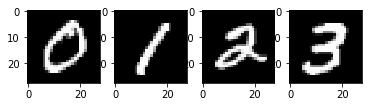

In [4]:
plt.subplot(1,4,1)
plt.imshow(x_train[0][:,:,0],cmap="gray")
plt.subplot(1,4,2)
plt.imshow(x_train[1][:,:,0],cmap="gray")
plt.subplot(1,4,3)
plt.imshow(x_train[2][:,:,0],cmap="gray")
plt.subplot(1,4,4)
plt.imshow(x_train[4][:,:,0],cmap="gray")
plt.show()

### Model Implementation

In [5]:
def get_encoder():
    """ Encoder model
    """
    x = Input(shape=(28,28,1))
    h = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation='relu')(x) # 14x14x32
    h = Conv2D(filters=16,kernel_size=3,strides=2,padding='valid',activation='relu')(h) # 7x7x16
    h = Conv2D(filters=8,kernel_size=3,strides=2,padding='same',activation='sigmoid')(h) # 3x3x8 -> unit hypercube
    h = Flatten()(h) # nx72
    
    model = Model(inputs=x,outputs=h)
    return model
    
def get_decoder():
    """ Decoder model
    """
    x = Input(shape=(72))
    h = Reshape((3,3,8))(x)
    h = Conv2DTranspose(filters=16,kernel_size=3,strides=2,padding='valid',activation='relu')(h) # 7x7x16
    h = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',activation='relu')(h) # 14x14x32
    o = Conv2DTranspose(filters=1,kernel_size=3,strides=2,padding='same',activation='sigmoid')(h) # 28x28x1
    
    model = Model(inputs=x,outputs=o)
    return model

In [6]:
def get_prototype_network(encoder,decoder,embedder):
    """ Prototype network
    """
    x = Input(shape=(28,28,1))
    e = encoder(x)
    d = decoder(e)
    emb_input=Input(shape=(8))
    prototypes = embedder(emb_input)
    
    e_rep = RepeatVector(8)(e)
    prototype_distances = tf.sqrt(tf.reduce_sum((e_rep-prototypes)**2,axis=-1)) # euclidian dist. between input embedding and each prototype 
    pred = Dense(4,activation='softmax')(prototype_distances)
    
    model = Model(inputs=[x,emb_input],outputs=[d,e,prototypes,pred])
    return model

In [7]:
# embedding layer is used to represent the prototype vectors
embedder = Embedding(input_dim=8,output_dim=72,weights=[Activation('sigmoid')(np.random.randn(8,72).astype("float32")).numpy()])
encoder = get_encoder()
decoder = get_decoder()

model = get_prototype_network(encoder,decoder,embedder)

In [8]:
def loss_func(y_train_subset,pred,x_train_subset,dec,e,prototypes,proto_lam=0.05,input_lam=0.05,enc_lam=0.05):
    """
    """
    pred_loss = SparseCategoricalCrossentropy()(y_train_subset,pred)
    enc_loss = tf.sqrt(MeanSquaredError()(x_train_subset,dec))
    
    e_ = tf.expand_dims(e,axis=0)
    prototypes_ = tf.expand_dims(prototypes[0,:,:],axis=1)
    prototype_input_euclid_dist = tf.sqrt(tf.reduce_sum((tf.subtract(e_,prototypes_))**2,axis=-1)) # n_prototypes x n_inputs
    prototype_min_dist = tf.reduce_mean(tf.reduce_min(prototype_input_euclid_dist,axis=1)) # min distance from each prototype to an input
    input_min_dist = tf.reduce_mean(tf.reduce_min(prototype_input_euclid_dist,axis=0)) # min distance from each input to a prototype
    
    loss = pred_loss+(enc_lam*enc_loss)+(proto_lam*prototype_min_dist)+(input_lam*input_min_dist)
    return loss

In [9]:
@tf.function
def train(model,optimizer,x_train_subset,emb_input,y_train_subset):
    """
    """
    with tf.GradientTape() as tape:
        dec,e,prototypes,pred = model([x_train_subset,emb_input])
        loss = loss_func(y_train_subset,pred,x_train_subset,dec,e,prototypes)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

### Model training

In [10]:
batch_size=200
optimizer=Adam(lr=0.01)
epochs=10
emb_input = np.array([[0,1,2,3,4,5,6,7] for _ in range(batch_size)])

for epoch_i in range(epochs):
    losses = []
    for i in range(0,len(x_train),batch_size):
        x_train_subset = x_train[i:i+batch_size]
        y_train_subset = y_train[i:i+batch_size]
        batch_loss = train(model,optimizer,x_train_subset,emb_input,y_train_subset)
        losses.append(float(batch_loss))
        
    print("Epoch {}: {}".format(epoch_i+1,round(sum(losses)/len(losses),6)))

Epoch 1: 0.636949
Epoch 2: 0.224186
Epoch 3: 0.15855
Epoch 4: 0.134991
Epoch 5: 0.121873
Epoch 6: 0.112951
Epoch 7: 0.105664
Epoch 8: 0.100451
Epoch 9: 0.095307
Epoch 10: 0.088935


In [11]:
prototype_emb = embedder(np.array([0,1,2,3,4,5,6,7]))
d = decoder(prototype_emb)[:,:,:,0]

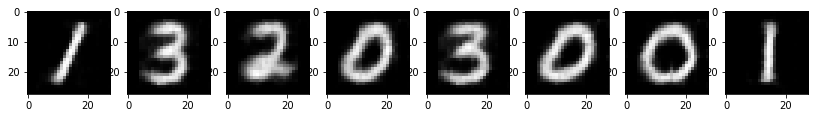

In [12]:
plt.figure(figsize=(14,4))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(d[i,:,:],cmap="gray")

plt.show()